# LSTM

## INTRO

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to handle sequence prediction problems. It is particularly effective in capturing long-term dependencies in sequential data.

- Sequential Input: LSTM processes input data sequentially, one element at a time, while maintaining an internal state.
- Forget Gate: At each time step, the LSTM decides what information to keep or forget from the internal state. This is done using a "forget gate" that takes the input and the previous state as inputs and outputs a number between 0 and 1 for each element in the internal state. A value of 1 means "keep this" and 0 means "forget this".
- Input Gate: Next, the LSTM decides what new information to store in the internal state. This is done through an "input gate" that takes the input and the previous state as inputs, processes them, and outputs a new candidate value for the internal state.
- Update the State: The internal state is updated by combining the information from the forget gate and the input gate. The forget gate decides what to remove from the state, and the input gate decides what to add.
- Output Gate: Finally, the LSTM decides what to output based on the updated internal state. This is done using an "output gate" that takes the input and the current state, processes them, and produces the output for the current time step.

# GRU

## Intro

Gated Recurrent Unit (GRU) is another type of recurrent neural network (RNN) architecture, similar to LSTM but somewhat simpler. It is designed to capture dependencies in sequential data.

- Update Gate: GRU has an update gate that controls how much of the previous state to keep and how much of the new state to add. It takes the input and the previous state, processes them, and decides what information to update in the current state.
- Reset Gate: There's also a reset gate that helps the model decide how much of the previous state to forget. It takes the input and the previous state, processes them, and decides what information to reset.
- Current Memory: GRU computes a new current memory based on the input, the previous state, and the update gate. It decides how much of the previous state to keep and how much of the new state to add.
- Output: Finally, GRU produces an output based on the current memory. This output can be used for predictions or passed to the next time step as input.


### Tensorflow

For the sake of my sanity, I am not building the models. Luckily, **Tensorflow.keras** comes with a semi-built-in option to construct RNNs with either/both methods (ore even some extra steps).

In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from data_funcs import *

In [7]:
portfolio_dict, portfolio = get_data(randomness=True)

100%|██████████| 31/31 [00:11<00:00,  2.81it/s]


In [8]:
portfolio['stocks']['AMD'].head()

,Adj Close,Close,High,Low,Open,Volume,day sin,returns
0,152.160004,152.160004,153.020004,151.050003,151.570007,3217015.0,-0.625923,0.004091
1,152.339996,152.339996,152.470001,151.389999,152.115005,2123003.0,-0.642788,0.001183
2,153.315308,153.315308,153.380005,152.107803,152.339996,2585205.0,-0.659346,0.006402
3,153.420197,153.420197,153.509995,152.601593,153.300003,1760709.0,-0.675590,0.000684
4,154.100006,154.100006,154.139999,153.400101,153.440002,2102916.0,-0.691513,0.004431


The model will predict the necesary data to calculate the KPIs and performance meassures:

- High
- Low
- Close
- Adj Close

Using **all** of the variables in a 6-window periodn from that specific stock (df)

| $\hat{x}$<sub>t-5</sub> | $\hat{x}$<sub>t-4</sub> | $\hat{x}$<sub>t-3</sub> | $\hat{x}$<sub>t-2</sub> | $\hat{x}$<sub>t-1</sub> | $\hat{x}$<sub>t</sub> | $\hat{y}$ |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| df.iloc[ 0, : ] | df.iloc[ 1, : ] | df.iloc[ 2, : ] | df.iloc[ 3, : ] | df.iloc[ 4, : ] | df.iloc[ 5, : ] | [High<sub>6</sub>, Low<sub>6</sub>, Close<sub>6</sub>, Adj_Close<sub>6</sub>] |
| df.iloc[ 1, : ] | df.iloc[ 2, : ] | df.iloc[ 3, : ] | df.iloc[ 4, : ] | df.iloc[ 5, : ] | df.iloc[ 6, : ] | [High<sub>7</sub>, Low<sub>7</sub>, Close<sub>7</sub>, Adj_Close<sub>7</sub>] |
| df.iloc[ 2, : ] | df.iloc[ 3, : ] | df.iloc[ 4, : ] | df.iloc[ 5, : ] | df.iloc[ 6, : ] | df.iloc[ 7, : ] | [High<sub>8</sub>, Low<sub>8</sub>, Close<sub>8</sub>, Adj_Close<sub>8</sub>] |
| df.iloc[ 3, : ] | df.iloc[ 4, : ] | df.iloc[ 5, : ] | df.iloc[ 6, : ] | df.iloc[ 7, : ] | df.iloc[ 8, : ] | [High<sub>9</sub>, Low<sub>9</sub>, Close<sub>9</sub>, Adj_Close<sub>9</sub>] |
| ... | ... | ... | ... | ... | ... | ... |

## Split the data

In [9]:
df = portfolio['stocks']['AMD'].copy()
targets = df.loc[:, ['High', 'Low', 'Close', 'Adj Close']].to_numpy()
df = df.to_numpy()
X = []
Y = []
window = 6

for i in range(len(df)-window):
    r = [x for x in df[i:i+window]]
    X.append(r)
    Y.append(targets[i+window])

X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

((305, 6, 8), (305, 4))

In [10]:
idx = 8*int(X.shape[0]/10)
X_train = X[:idx, :, :]
Y_train = Y[:idx, :]
X_test =  X[idx:, :, :]
Y_test =  Y[idx:, :]

X_train.shape, Y_test.shape

((240, 6, 8), (65, 4))

## Standarization

In [11]:
x_means = [np.mean(X_train[:, :, i]) for i in range(X_train.shape[2])]
x_stds = [np.std(X_train[:, :, i]) for i in range(X_train.shape[2])]

X_train_p = (X_train-x_means)/x_stds
X_test_p = (X_test-x_means)/x_stds
    
y_means = [np.mean(Y_train[:, i]) for i in range(Y_train.shape[1])]
y_stds = [np.std(Y_train[:, i]) for i in range(Y_train.shape[1])]

Y_train_p = (Y_train-y_means)/y_stds
Y_test_p = (Y_test-y_means)/y_stds

## Turn everything into a func

In [12]:
def preprocess(DF, window=6):
    df = DF.copy()
    targets = df.loc[:, ['High', 'Low', 'Close', 'Adj Close']].to_numpy()
    df = df.to_numpy()
    X = []
    Y = []

    for i in range(len(df)-window):
        r = [x for x in df[i:i+window]]
        X.append(r)
        Y.append(targets[i+window])

    X = np.array(X)
    Y = np.array(Y)
    
    idx = 7*int(X.shape[0]/10)
    idx2 = 9*int(X.shape[0]/10)
    X_train = X[:idx, :, :]
    Y_train = Y[:idx, :]
    X_test =  X[idx:idx2, :, :]
    Y_test =  Y[idx:idx2, :]
    X_val =  X[idx2:, :, :]
    Y_val =  Y[idx2:, :]
    
    x_means = [np.mean(X_train[:, :, i]) for i in range(X_train.shape[2])]
    x_stds = np.array([np.std(X_train[:, :, i]) for i in range(X_train.shape[2])])
    x_stds = np.where(x_stds == 0, 1, x_stds)

    X_train_p = (X_train-x_means)/x_stds
    X_test_p = (X_test-x_means)/x_stds
    X_val_p = (X_val-x_means)/x_stds
        
    y_means = [np.mean(Y_train[:, i]) for i in range(Y_train.shape[1])]
    y_stds = [np.std(Y_train[:, i]) for i in range(Y_train.shape[1])]

    Y_train_p = (Y_train-y_means)/y_stds
    Y_test_p = (Y_test-y_means)/y_stds
    Y_val_p = (Y_val-y_means)/y_stds
    
    return [X_train_p, X_test_p, X_val_p, x_means, x_stds], [Y_train_p, Y_test_p, Y_val_p, y_means, y_stds]

In [13]:
X, Y = {}, {}

for eq in portfolio_dict:
    for tckr in portfolio_dict[eq]:
        X[tckr], Y[tckr] = preprocess(portfolio[eq][tckr])

# Models

Because of the nature of the diversification, the project aims to buils a model for each type of equity. If computational load is not an issue, a model for every ticker would be better

In [14]:
models, checkpoints = {}, {}

for eq in portfolio_dict:
    for stck in portfolio_dict[eq]: 
        models[stck] = Sequential()
        models[stck].add(InputLayer((6, 8)))
        models[stck].add(LSTM(64))
        models[stck].add(Dense(8, 'relu'))
        models[stck].add(Dense(4, 'linear'))
        checkpoints[stck] = ModelCheckpoint('{}/'.format(stck), save_best_only=True)

In [15]:
models['VOO'].summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                18688     
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
Total params: 19244 (75.17 KB)
Trainable params: 19244 (75.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
for eq in portfolio_dict:
        for stck in portfolio_dict[eq]:
                print(stck)
                models[stck].compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.005), metrics=[RootMeanSquaredError()])
                models[stck].fit(X[stck][0], Y[stck][0], validation_data=(X[stck][1], Y[stck][1]), epochs=3, callbacks=[checkpoints[stck]])
                print("NEXT \n")

In [17]:
today_data = get_data()

100%|██████████| 31/31 [00:03<00:00,  8.48it/s]


In [69]:
tckr = 'VOO'
y = models[tckr].predict(X[tckr][2]) # Validation data
y_p = y*Y[tckr][4]+Y[tckr][3]
y_real = Y[tckr][2]*Y[tckr][4]+Y[tckr][3]

2/2 [==============================] - 0s 4ms/step


In [70]:
data = {
    'Actual High': y_real[:, 0],
    'Predicted High': y_p[:, 0],
    'Actual Low': y_real[:, 1],
    'Predicted Low': y_p[:, 1],
    'Actual Close': y_real[:, 2],
    'Predicted Close': y_p[:, 2],
    'Adj Close': y_real[:, 3],
    'Predicted Adj Close': y_p[:, 3]
}

In [75]:
def Predictions(X, Y):
    preds = {}
    for tckr in list(X.keys()):
        y = models[tckr].predict(X[tckr][2]) # Validation data
        y_p = y*Y[tckr][4]+Y[tckr][3]
        y_real = Y[tckr][2]*Y[tckr][4]+Y[tckr][3]
        data = {
            'Actual High': y_real[:, 0],
            'Predicted High': y_p[:, 0],
            'Actual Low': y_real[:, 1],
            'Predicted Low': y_p[:, 1],
            'Actual Close': y_real[:, 2],
            'Predicted Close': y_p[:, 2],
            'Actual Adj Close': y_real[:, 3],
            'Predicted Adj Close': y_p[:, 3]
        }
        preds[tckr] = pd.DataFrame(data=data)
    return preds

In [76]:
preds = Predictions(X, Y)

2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 2ms/step


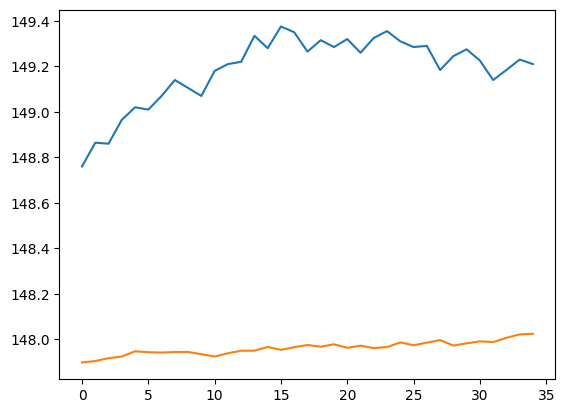

In [84]:
import matplotlib.pyplot as plt

tckr = 'VTV'
plt.plot(preds[tckr]['Adj Close'])
plt.plot(preds[tckr]['Predicted Adj Close'])